# Step 2: Image Preprocessing & Dataset Loading

In this step we standardize images and build loaders for three sources:

- **Fruits 360** (studio, 100×100, RGB → our grayscale pipeline)
- **Fruits Fresh & Rotten** — fresh-only (in-the-wild; used for domain evaluation)
- **Fruit-262** (our own split; used for domain evaluation and/or extra classes)

All inputs are padded to a square and then resized to 100×100 during loading, ensuring consistent tensors (N, C, 100, 100) across datasets.

## 2.1 Project Hypotheses Supported

- **Grayscale Hypothesis** — Grayscale (+ equalization) can match RGB while using fewer resources
- **Model Simplicity Hypothesis** — A small CNN can approach MobileNetV2 with far fewer params
- **Quantization Hypothesis** — PTQ (fp32→int8) speeds inference and shrinks size with minimal accuracy loss

Training data uses grayscale-specific augmentations; validation/test remain clean.

## 2.2 Preprocessing Strategy

**Train (augmented):** Grayscale + equalize → random flip/affine/jitter/perspective/shear → PadToSquare → Resize(100×100) → Normalize to [-1,1]

**Val/Test (clean):** Grayscale + equalize → PadToSquare → Resize(100×100) → Normalize

**Dataset-size normalization:** To match Fruits360 scale (≈200–220/class), we cap the training portions of Fresh-only and Fruit-262 to ~200 images per class (seed=42). Val/Test stay untouched.

## 2.3 Dataset Loading and Splitting

- **Fruits360:** use Training/ (split 80/20 into train/val deterministically) + provided Test/
- **Fresh-only:** evaluation loader; labels remapped (e.g., freshapples → Apple) to match the canonical class order from Fruits360
- **Fruit-262:** use our generated train/val/test split; loaders aligned to the same canonical class order

We also compute class weights on Fruits360 train for CrossEntropyLoss. Metrics (incl. Macro-F1) are computed in later steps.

## 2.4 Visualization of Preprocessed Samples

We show a small batch from the Fruits360 training loader to confirm transforms.

## 2.5 Summary

This step delivers:

- Uniform 100×100 grayscale tensors via Pad→Resize for all datasets
- Augmented training + clean val/test pipelines
- Balanced training counts via capping (~200/class) for non-Fruits360 sources
- Canonical, aligned label space across domains



In [11]:
import os, sys, json, torch
sys.path.append(os.path.abspath("../src"))
from viz import show_batch

from utils import seed_everything, ensure_dir
from data import (
    make_dataloaders,          # Fruits360 loaders (train/val/test)
    make_canonical_loader,     # Domain loaders aligned to canonical classes
    build_domain_loaders,      # convenience wrapper
    cap_per_class,             # cap large domains to ~200/class
)



In [12]:
TRAIN_DIR = '../Dataset/Training'
TEST_DIR  = '../Dataset/Test'
os.makedirs("../reports/figures", exist_ok=True)


seed_everything(42)

# Paths
FR360_TRAIN = "../Dataset/Training"
FR360_TEST  = "../Dataset/Test"

FRESH_TRAIN = "../Dataset-hybrid/fresh_rotten/train"   # use only fresh* folders
F262_SPLIT  = "../Dataset-hybrid/fruit262_split"       # has train/val/test

ensure_dir("../reports/figures")



[INFO] Global seed set to 42


WindowsPath('../reports/figures')

#### Cap larger domains to ~200/class (train only)

In [13]:
CAP_PER_CLASS = 200
cap_per_class(FRESH_TRAIN, CAP_PER_CLASS, seed=42)
cap_per_class(os.path.join(F262_SPLIT, "train"), CAP_PER_CLASS, seed=42)
print(f"[INFO] Capped Fresh-only + Fruit-262 train splits to {CAP_PER_CLASS}/class.")



[INFO] Capped Fresh-only + Fruit-262 train splits to 200/class.


#### Fruits360 loaders (train/val/test) with grayscale aug

In [14]:
train_loader, val_loader, test_loader, class_weights, class_names, in_ch = make_dataloaders(
    train_dir=FR360_TRAIN,
    test_dir=FR360_TEST,
    batch_size=32,
    val_split=0.2,       # 80/20 from Fruits360 Training
    img_size=100,
    num_workers=0,       # safest on Windows
    seed=42,
    mode="grayscale",
    verbose=True
)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
print("in_channels:", in_ch)
print("Classes (canonical):", class_names)
print("Class weights (mean≈1):", class_weights.numpy().round(3))

[INFO] Seed: 42
[INFO] Mode: grayscale (in_channels=1, use_noise=False)
[INFO] Classes (8): ['Apple Red 1', 'Avocado 1', 'Banana 1', 'Kiwi 1', 'Orange 1', 'Pineapple 1', 'Strawberry 1', 'Tomato 1']
[INFO] Sizes -> train: 3260, val: 814, test: 1365
[INFO] Class weights (mean≈1): [1.011 1.165 1.016 1.068 1.039 1.016 1.011 0.674]
in_channels: 1
Classes (canonical): ['Apple Red 1', 'Avocado 1', 'Banana 1', 'Kiwi 1', 'Orange 1', 'Pineapple 1', 'Strawberry 1', 'Tomato 1']
Class weights (mean≈1): [1.011 1.165 1.016 1.068 1.039 1.016 1.011 0.674]


#### Domain loaders: Fresh-only & Fruit-262 aligned to canonical classes

In [15]:
# --- Domain loaders with correct mapping to Fruits-360 class names (mode-aware) ---

import os
from pathlib import Path
from data import build_domain_loaders

# 1) Fresh & Rotten (fresh*) -> Fruits-360 canonical names
FRESH_TO_FR360 = {
    "freshapples":   "Apple Red 1",
    "freshbanana":   "Banana 1",
    "freshoranges":  "Orange 1",
    # add more ONLY if you have the matching Fruits-360 class (e.g., "Strawberry 1", "Tomato 1")
}

# 2) Fruit-262 -> Fruits-360 canonical names
# Make sure keys match the actual folder names under fruit262_split (usually lowercase)
F262_TO_FR360 = {
    "Avocado":    "Avocado 1",
    "Kiwi":       "Kiwi 1",
    "Pineapple":  "Pineapple 1",
    "Strawberry": "Strawberry 1",
    "Tomato":     "Tomato 1",
}

# Helper: keep only mappings whose raw folder exists on disk AND whose target is in our canonical list
def filter_map_to_canon(raw2canon, root_dir, canon_list):
    root = Path(root_dir)
    raw_present = {d.name for d in root.iterdir() if d.is_dir()} if root.exists() else set()
    canon_set = set(canon_list)
    return {raw: canon for raw, canon in raw2canon.items() if (raw in raw_present and canon in canon_set)}

FRESH_MAP = filter_map_to_canon(FRESH_TO_FR360, FRESH_TRAIN, class_names)
F262_MAP  = filter_map_to_canon(F262_TO_FR360, os.path.join(F262_SPLIT, "train"), class_names)

# 3) Build loaders (grayscale by default; switch mode="rgb" if you want RGB tests)
loaders = build_domain_loaders(
    canonical_classes=class_names,
    fresh_root=FRESH_TRAIN, fresh_map=FRESH_MAP,
    f262_root=F262_SPLIT,  f262_map=F262_MAP,
    mode="grayscale",               # or "rgb"
    batch_size=32, img_size=100, num_workers=0,
    fresh_aug=False, f262_train_aug=False,
    shuffle_fresh=False, shuffle_f262_train=False,
)

fresh_eval_loader = loaders["fresh_eval"]
f262_train_loader = loaders["f262_train"]
f262_val_loader   = loaders["f262_val"]
f262_test_loader  = loaders["f262_test"]

print("[INFO] Fresh-only eval samples:", len(fresh_eval_loader.dataset))
print("[INFO] Fruit-262 samples -> train:", len(f262_train_loader.dataset),
      "val:", len(f262_val_loader.dataset), "test:", len(f262_test_loader.dataset))



[INFO] Fresh-only eval samples: 600
[INFO] Fruit-262 samples -> train: 1000 val: 1040 test: 1050


In [16]:
#### Sanity check: confirm 100×100 everywhere

In [17]:
def assert_loader_size(loader, name, expected_hw=(100, 100)):
    n = len(loader.dataset)
    if n == 0:
        print(f"[SKIP] {name}: dataset is empty (0 samples).")
        return
    x, _ = next(iter(loader))
    assert tuple(x.shape[-2:]) == expected_hw, f"{name} not {expected_hw}, got {x.shape}"
    print(f"[OK] {name}: batch={tuple(x.shape)}, samples={n}")

# call it:
assert_loader_size(train_loader,       "Fruits360 train")
assert_loader_size(val_loader,         "Fruits360 val")
assert_loader_size(test_loader,        "Fruits360 test")
assert_loader_size(fresh_eval_loader,  "Fresh-only eval")
assert_loader_size(f262_test_loader,   "Fruit-262 test")



[OK] Fruits360 train: batch=(32, 1, 100, 100), samples=3260
[OK] Fruits360 val: batch=(32, 1, 100, 100), samples=814
[OK] Fruits360 test: batch=(32, 1, 100, 100), samples=1365
[OK] Fresh-only eval: batch=(32, 1, 100, 100), samples=600
[OK] Fruit-262 test: batch=(32, 1, 100, 100), samples=1050


In [18]:
#### Visualize a batch

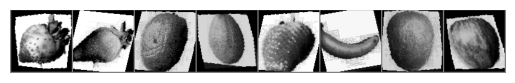

Image 1: Strawberry 1
Image 2: Strawberry 1
Image 3: Kiwi 1
Image 4: Avocado 1
Image 5: Strawberry 1
Image 6: Banana 1
Image 7: Kiwi 1
Image 8: Apple Red 1


In [19]:
images, labels = next(iter(train_loader))
show_batch(images, labels, class_names, grayscale=True, n=8)

In [20]:
import json, os
from utils import ensure_dir
DATASET_CFG = {
    "seed": 42, "img_size": 100, "batch_size": 32, "num_workers": 0,
    "cap_per_class": 200, "mode": "grayscale",
    "fr360_train": "../Dataset/Training",
    "fr360_test":  "../Dataset/Test",
    "fresh_root":  "../Dataset-hybrid/fresh_rotten/train",
    "f262_root":   "../Dataset-hybrid/fruit262_split",
    "canonical_classes": list(class_names),
    "fresh_map": dict(FRESH_MAP),
    "f262_map":  dict(F262_MAP),
}
ensure_dir("../configs")
with open("../configs/dataset_config.json","w",encoding="utf-8") as f:
    json.dump(DATASET_CFG, f, indent=2)
print("[INFO] Saved dataset_config.json")


[INFO] Saved dataset_config.json
